# Notebook zur Evaluation der trainierten Modelle

In [14]:
# Library imports
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb

In [15]:
# Allow imports from the src directory
import sys
import os
from pathlib import Path
path_src_dir = os.path.join(str(Path(os.path.dirname(os.path.abspath(os.path.abspath('')))).parents[0]), 'hivefive', 'src')
path_modeling_dir = os.path.join(path_src_dir, 'modeling')
sys.path.append(path_src_dir)
sys.path.append(path_modeling_dir)

In [16]:
# Import of local files
import config
from train import Train
from model import CNNModel
from yamnet import YamnetTransferModel
import model_evaluation

In [5]:
metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['sample_name', "label", "hive_number", "segment",]
metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)

metadata_df.head()

,sample_name,label,hive_number,segment
0,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment0
1,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment1
2,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment2
3,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment3
4,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment4


# Training auf allen Daten

In [7]:
model_name = 'model_20240923_131940_19_all_data'

trainer = Train(CNNModel(), nn.BCELoss())
checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer.load_model(checkpoint_path, model, optimizer)
model = model_loaded

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
torch.onnx.export(model, next(iter(trainer.training_dataloader))[0], model_name + "_CNN.onnx", input_names=["MEL-Spectrograms"], output_names=["predictions"])

In [8]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 27/27 [00:45<00:00,  1.69s/it]

torch.Size([860])


<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf allen Daten'}, xlabel='Predicted', ylabel='Actual'>

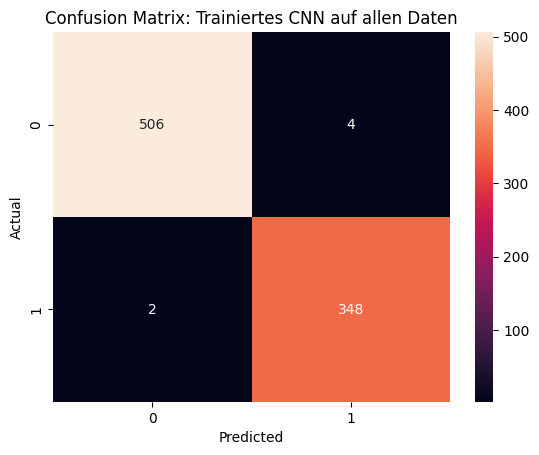

In [9]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf allen Daten")
plt

In [10]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       510
         1.0       0.99      0.99      0.99       350

    accuracy                           0.99       860
   macro avg       0.99      0.99      0.99       860
weighted avg       0.99      0.99      0.99       860



In [11]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

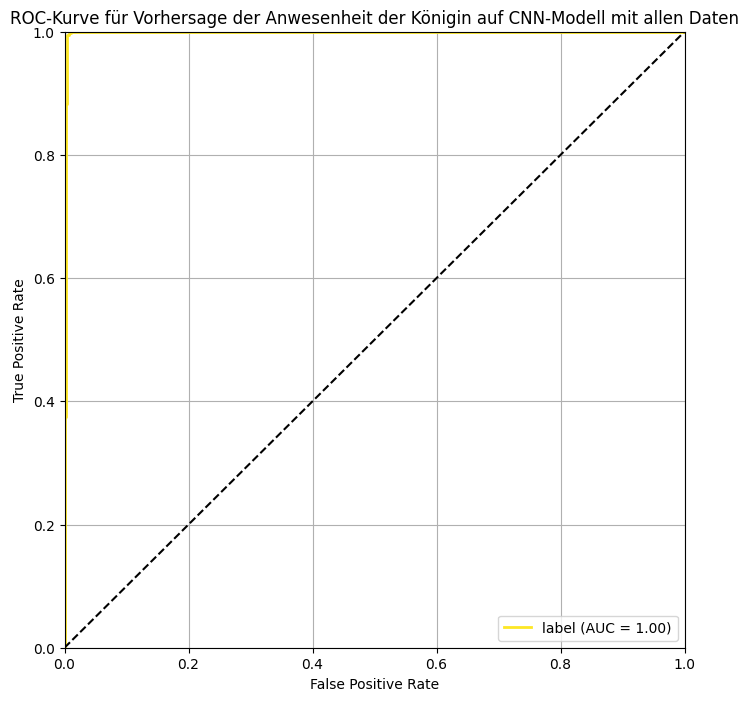

In [12]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Vorhersage der Anwesenheit der Königin auf CNN-Modell mit allen Daten")

# Hive-Independent

## Hive-Independent (Training-Hive 1, Test-Hive 3)

In [13]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=1)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [14]:
model_name = 'model_20240923_155143_18_training_hive1'

checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [15]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 90/90 [02:28<00:00,  1.65s/it]

torch.Size([2857])


<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 1'}, xlabel='Predicted', ylabel='Actual'>

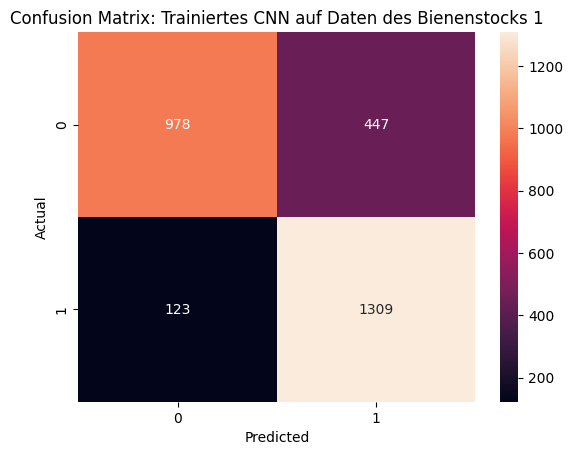

In [16]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 1")
plt

In [17]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.89      0.69      0.77      1425
         1.0       0.75      0.91      0.82      1432

    accuracy                           0.80      2857
   macro avg       0.82      0.80      0.80      2857
weighted avg       0.82      0.80      0.80      2857



In [18]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

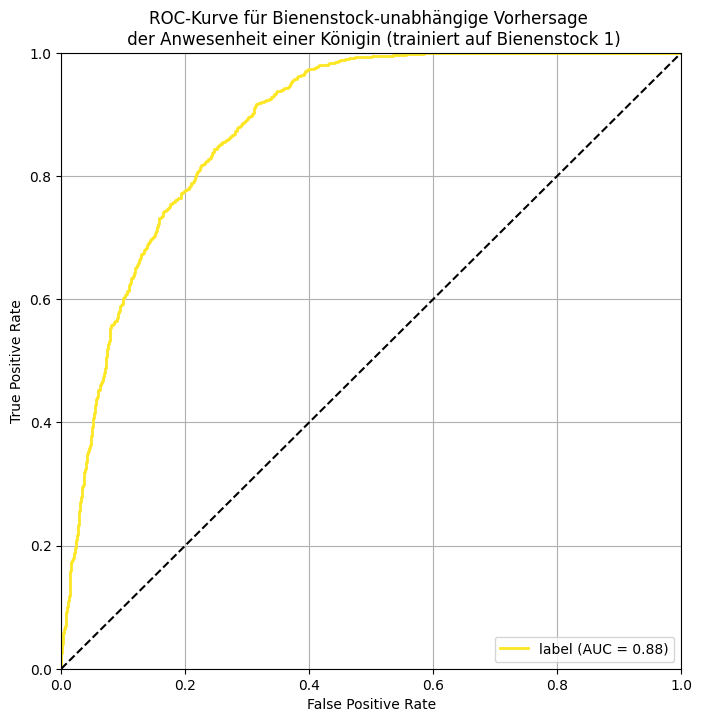

In [19]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Bienenstock-unabhängige Vorhersage \n der Anwesenheit einer Königin (trainiert auf Bienenstock 1)")

## Hive-Independent (Training-Hive 3, Test-Hive 1)

In [20]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=3)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [21]:
model_name = 'model_20240923_171634_19_training_hive3'

checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [23]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 89/89 [02:28<00:00,  1.67s/it]

torch.Size([2832])


<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 3'}, xlabel='Predicted', ylabel='Actual'>

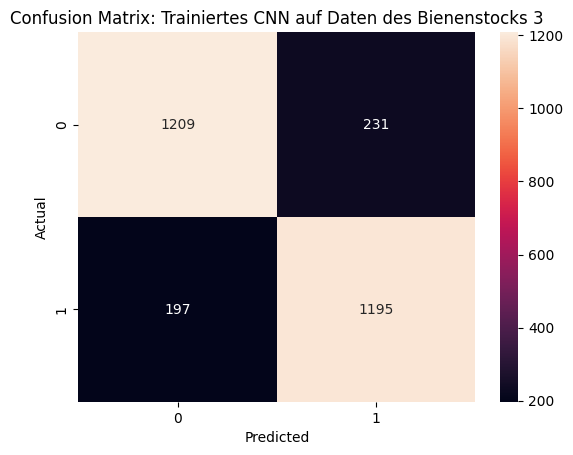

In [24]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 3")
plt

In [25]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1440
         1.0       0.84      0.86      0.85      1392

    accuracy                           0.85      2832
   macro avg       0.85      0.85      0.85      2832
weighted avg       0.85      0.85      0.85      2832



In [26]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

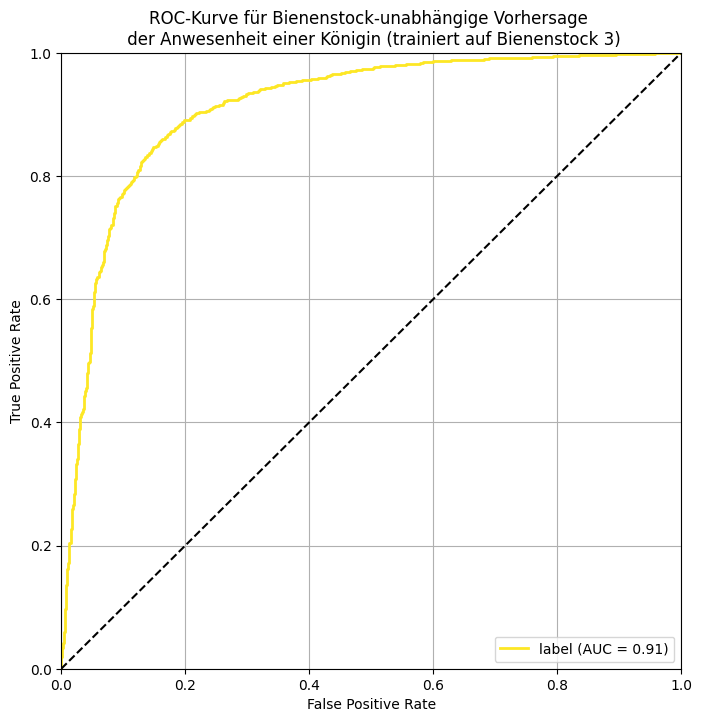

In [27]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Bienenstock-unabhängige Vorhersage \n der Anwesenheit einer Königin (trainiert auf Bienenstock 3)")

# Transfer Learning Modell (Training auf allen Daten)

In [ ]:
trainer_yamnet = Train(YamnetTransferModel(), nn.BCELoss(), dataset="WAV")

In [ ]:
model_name = 'model_20240923_151237_0'

checkpoint_path = '../../models/final/' + model_name + '_checkpoint.pt'
model = YamnetTransferModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_yamnet.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_yamnet.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

In [ ]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes Transfer Learning Modell (auf allen Daten)")
plt

In [ ]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

In [ ]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

In [ ]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Vorhersage \n der Anwesenheit einer Königin (Transfer Learning)")